## Machine Learning Model Building Pipeline: Big Data, Images and Neural Networks

Building a Convolutional Neural Network on our Image dataset of over 1GB in size

## Differentiating weed from crop seedlings

The aim of the project is to correctly identify the weed type from a variety of weed and crop RGB images.

### Why is this important?

As taken from Kaggle website:

"Successful cultivation of maize depends largely on the efficacy of weed control. Weed control during the first six to eight weeks after planting is crucial, because weeds compete vigorously with the crop for nutrients and water during this period. Annual yield losses occur as a result of weed infestations in cultivated crops. Crop yield losses that are attributable to weeds vary with type of weed, type of crop, and the environmental conditions involved. Generally, depending on the level of weed control practiced yield losses can vary from 10 to 100 %. Thereore, effective weed control is imperative. In order to do effective control the first critical requirement is correct weed identification."


### What is the objective of the machine learning model?

We aim to maximise the accuracy, that is, the correct classification of the different weed varieties.

### How do I download the dataset?

To download the House Price dataset go this website:
https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset

Click on the link 'train.csv', and then click the 'download (2GB)' button towards the right of the screen, to download the dataset. Unzip the folder and rename it to 'plant_train' and save it to a directory of your choice. If you save it to the same directory from where you run this notebook, then you will be able to run the code as I do in the notebook.

In [1]:
import pandas as pd
import numpy as np

# navigate folders
from glob import glob
import os

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to open the images
import cv2

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
# data preprocessing and separate to train and test set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model
from sklearn.metrics import confusion_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# for the convolutional network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

In [5]:
# create a variable to hold data folder
data_folder = '/content/drive/MyDrive/plant-image-datasets'

In [6]:
# list the folders in the data folder directory
os.listdir(data_folder)

['Small-flowered Cranesbill',
 'Charlock',
 'nonsegmentedv2',
 'Fat Hen',
 'Maize',
 'Shepherds Purse',
 'Black-grass',
 'Common wheat',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Sugar beet',
 'Cleavers',
 'Common Chickweed']

In [7]:
# working over the directory structure so as understand how
# the images are stored
for class_folder_name in os.listdir(data_folder):
    class_folder_path = os.path.join(data_folder,class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, '*.png')):
        print(image_path)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/7.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/98.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/89.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/62.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/561.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/562.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/6.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/72.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/82.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/565.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/75.png
/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/93.png
/content/drive/MyDrive/p

In [8]:
# let's create a dataframe
# the dataframe will store the path to the image in one column
# and the class of the weed(target) in the next column

images_df = []


# navigate within each folder
for class_folder_name in os.listdir(data_folder):
    class_folder_path = os.path.join(data_folder,class_folder_name)

    # collect every image path
    for image_path in glob(os.path.join(class_folder_path, '*.png')):

        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)


# concatenate the final df

images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

,image,target
0,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
1,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
2,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
3,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
4,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
5,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
6,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
7,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
8,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill
9,/content/drive/MyDrive/plant-image-datasets/Sm...,Small-flowered Cranesbill


In [9]:
images_df.shape

(5539, 2)

In [10]:
# checking how many images we have per class
images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

In [11]:

# retrieve only a single image path or value
images_df.loc[0, 'image']

'/content/drive/MyDrive/plant-image-datasets/Small-flowered Cranesbill/102.png'

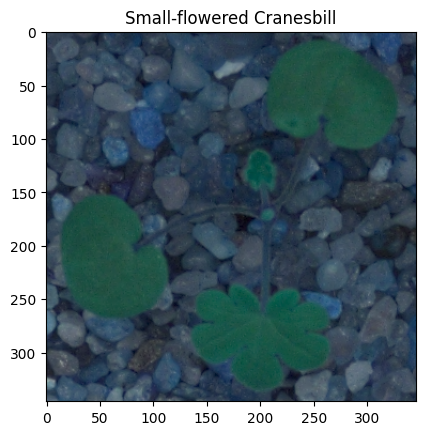

In [12]:

# visualizing our sample image

def plot_single_img(df, img_no):
    im = cv2.imread(df.loc[img_no, 'image'])
    plt.title(df.loc[img_no, 'target'])
    plt.imshow(im)


plot_single_img(images_df,0)

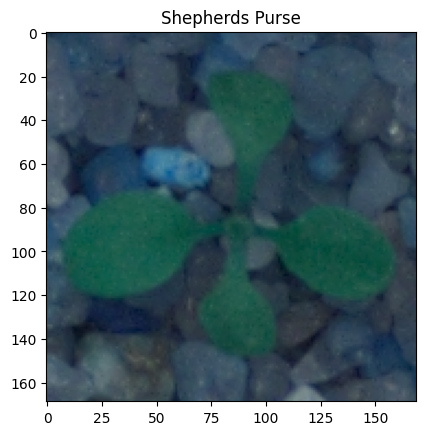

In [13]:
plot_single_img(images_df,2000)

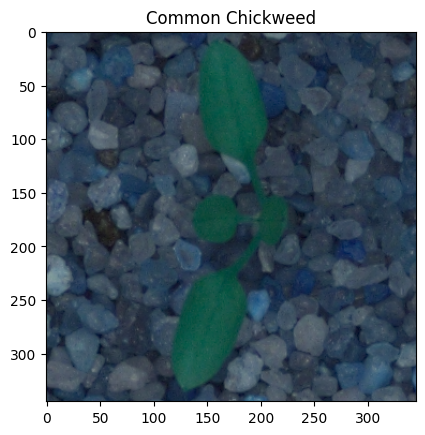

In [14]:
plot_single_img(images_df,5000)

In [15]:
# let;s plot a bunch of our images together in other to get a better
# feeling of a particular plant type

def plot_for_class(df, label):

    # function plots 9 images
    nb_rows = 3
    nb_cols = 3

    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10,10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label]
            tmp.reset_index(drop=True, inplace = True)
            im = cv2.imread(tmp.loc[n, 'image'])
            axs[i,j].imshow(im)
            n +=1

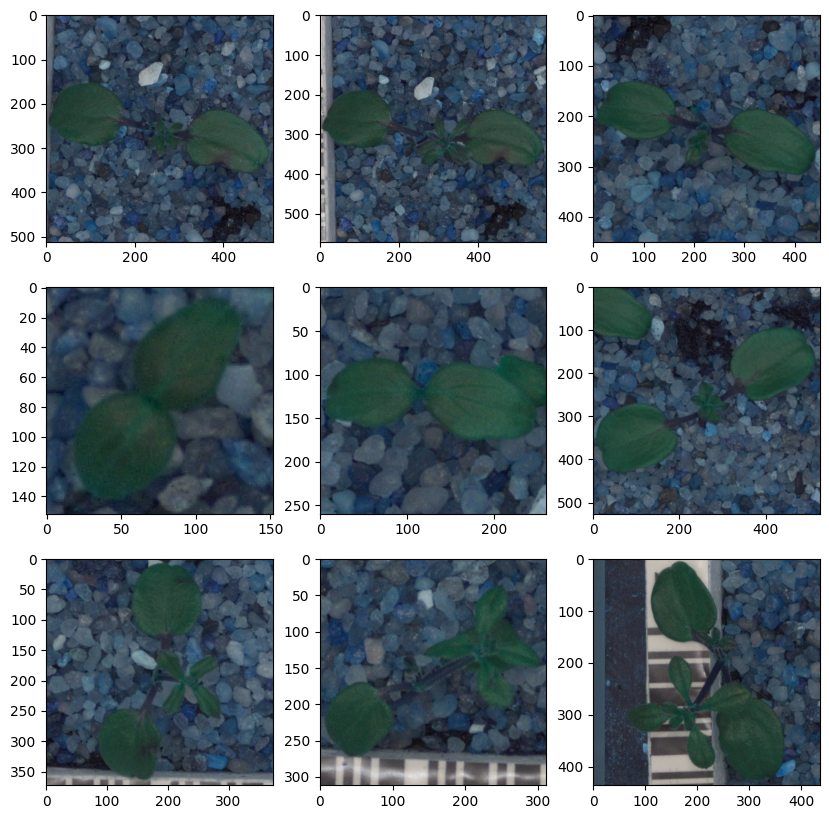

In [16]:
plot_for_class(images_df, 'Cleavers')

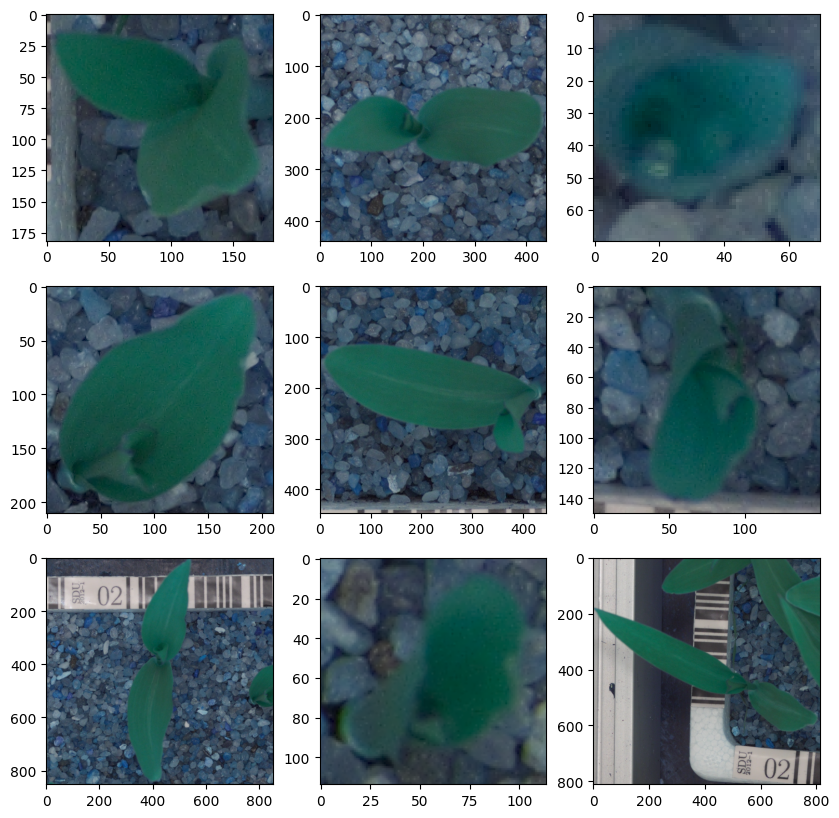

In [17]:
plot_for_class(images_df, 'Maize')

In [18]:
# Separate train and test data
# split our dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(images_df['image'],
                                                   images_df['target'],
                                                   test_size=0.2,
                                                   random_state=1)
print(x_train.shape)
print(x_test.shape)

(4431,)
(1108,)


In [19]:
x_train.head()

1586    /content/drive/MyDrive/plant-image-datasets/Ma...
4154    /content/drive/MyDrive/plant-image-datasets/Su...
1004    /content/drive/MyDrive/plant-image-datasets/Ch...
4954    /content/drive/MyDrive/plant-image-datasets/Co...
3484    /content/drive/MyDrive/plant-image-datasets/Sc...
Name: image, dtype: object

In [20]:
# since we randomized our variable selection, it would be important we
# reset our index, because we will be iterating over row numbers

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
x_train.head()

0    /content/drive/MyDrive/plant-image-datasets/Ma...
1    /content/drive/MyDrive/plant-image-datasets/Su...
2    /content/drive/MyDrive/plant-image-datasets/Ch...
3    /content/drive/MyDrive/plant-image-datasets/Co...
4    /content/drive/MyDrive/plant-image-datasets/Sc...
Name: image, dtype: object

In [21]:
# resetting index in target variable
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [22]:
# mean images within each class
y_train.value_counts()/len(y_train)

Loose Silky-bent             0.135184
Common Chickweed             0.130670
Scentless Mayweed            0.110585
Small-flowered Cranesbill    0.102234
Fat Hen                      0.096592
Charlock                     0.083728
Sugar beet                   0.083051
Cleavers                     0.061386
Black-grass                  0.056646
Shepherds Purse              0.048070
Maize                        0.046265
Common wheat                 0.045588
Name: target, dtype: float64

In [23]:
# mean images within each class
y_test.value_counts()/len(y_test)

Loose Silky-bent             0.147112
Common Chickweed             0.120939
Small-flowered Cranesbill    0.111011
Scentless Mayweed            0.105596
Fat Hen                      0.099278
Sugar beet                   0.085740
Charlock                     0.073105
Cleavers                     0.056859
Shepherds Purse              0.055054
Black-grass                  0.052347
Maize                        0.046931
Common wheat                 0.046029
Name: target, dtype: float64

In [24]:
# preparing the target variable
# since it is a multiclassification, so we need to make one hot encoding
# of the target

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

print(train_y.shape)
train_y

(4431, 12)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
# since the images in our folder are of different types, for the sake of
# our neural network, we need images in the same size. Hence we shall
# resize the images

IMAGE_SIZE = 150

In [26]:
x_train[7]

'/content/drive/MyDrive/plant-image-datasets/Fat Hen/141.png'

In [27]:

# create a function to aid in resizing all our images
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [28]:
#  we call our function
tmp = im_resize(x_train, 7)
tmp.shape

(150, 150, 3)

In [29]:
# the shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations
# n2 and n3 are image width and length
# and n4 indicates that it is a color image, so 3 planes per image

def create_dataset(df, image_size):
    # creating the dataset as required by our cnn model
    tmp = np.zeros((len(df), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = 'float32')

    for n in range(0, len(df)):
        im = im_resize(df,n)
        tmp[n] = im

    print('Dataset Images shape: {} size {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [30]:
# call the above function to create the dataset
x_train = create_dataset(x_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size 299,092,500


In [31]:
# Do same for the test data
x_test = create_dataset(x_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size 74,790,000


In [32]:
# return the number of different classes
len(y_train.unique())


12

In [33]:

# Building the CNN Model
# this is our cnn

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
# model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
# #model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

In [34]:
model.summary()
# let's compile the model
model.compile(Adam(lr=0.0001), loss='binary_crossentropy',
              metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [35]:
# specify batch size and epoch
batch_size = 10
epochs = 8


In [36]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=1,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

# let's compile the model
model.compile(Adam(lr=0.0001), loss='binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x = x_train, y = train_y,
                    batch_size=batch_size,
                    validation_split=10,
                    epochs=epochs,
                    validation_data=(x_test, test_y),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/8


444/444 - 776s - loss: 0.3551 - accuracy: 0.2119 - val_loss: 0.2789 - val_accuracy: 0.4088 - lr: 1.0000e-04 - 776s/epoch - 2s/step
Epoch 2/8


444/444 - 778s - loss: 0.2149 - accuracy: 0.4629 - val_loss: 0.1898 - val_accuracy: 0.6597 - lr: 1.0000e-04 - 778s/epoch - 2s/step
Epoch 3/8


444/444 - 789s - loss: 0.1645 - accuracy: 0.6148 - val_loss: 0.1464 - val_accuracy: 0.6958 - lr: 1.0000e-04 - 789s/epoch - 2s/step
Epoch 4/8


444/444 - 788s - loss: 0.1405 - accuracy: 0.6865 - val_loss: 0.1256 - val_accuracy: 0.7338 - lr: 1.0000e-04 - 788s/epoch - 2s/step
Epoch 5/8


444/444 - 770s - loss: 0.1198 - accuracy: 0.7468 - val_loss: 0.1203 - val_accuracy: 0.7681 - lr: 1.0000e-04 - 770s/epoch - 2s/step
Epoch 6/8


444/444 - 766s - loss: 0.1002 - accuracy: 0.7978 - val_loss: 0.1114 - val_accuracy: 0.7536 - lr: 1.0000e-04 - 766s/epoch - 2s/step
Epoch 7/8


444/444 - 776s - loss: 0.0857 - accuracy: 0.8337 - val_loss: 0.1116 - val_accuracy: 0.7572 - lr: 1.0000e-04 - 776s/epoch - 2s/step
Epoch 8/8


444/444 - 771s - loss: 0.0741 - accuracy: 0.8565 - val_loss: 0.0998 - val_accuracy: 0.8014 - lr: 1.0000e-04 - 771s/epoch - 2s/step


<Figure size 640x480 with 0 Axes>

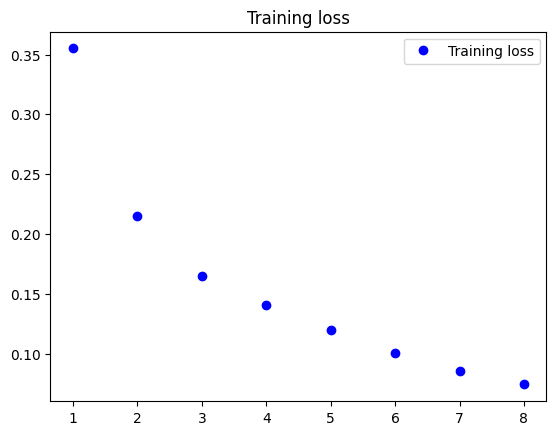

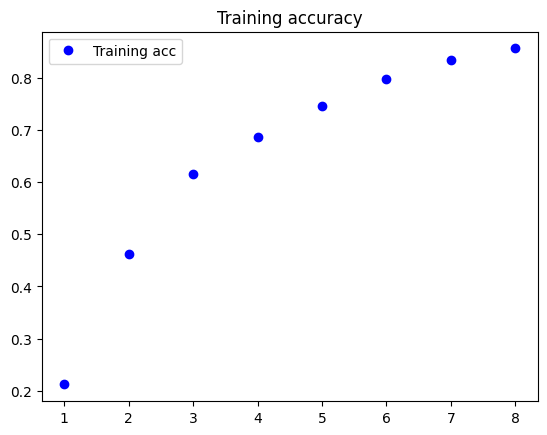

<Figure size 640x480 with 0 Axes>

In [37]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

In [38]:
# make a prediction

predictions = model.predict(x_test, verbose=1)

classes_x = np.argmax(predictions,axis=1)

classes_x

35/35 [==============================] - 44s 1s/step


array([ 7,  8,  8, ...,  7, 10, 10])

In [39]:
# transform target
encoder.transform(y_test)

array([ 7,  8,  8, ...,  7, 10, 10])

In [41]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), classes_x)

In [42]:
# create a dict to map back the numbers onto the classes

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values,index=tmp.class_number).to_dict()
tmp

{7: 'Maize',
 8: 'Scentless Mayweed',
 3: 'Common Chickweed',
 0: 'Black-grass',
 2: 'Cleavers',
 1: 'Charlock',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 6: 'Loose Silky-bent',
 5: 'Fat Hen',
 11: 'Sugar beet',
 4: 'Common wheat'}

In [43]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

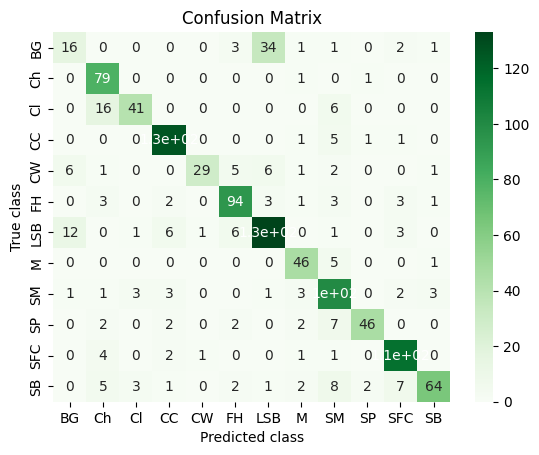

In [44]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show()

In [46]:
from sklearn.metrics import  accuracy_score


accuracy_score(encoder.transform(y_test), classes_x, normalize=True, sample_weight=None)

0.8014440433212996

In [48]:
from sklearn.metrics import  classification_report

print(classification_report(encoder.transform(y_test), classes_x))

              precision    recall  f1-score   support

           0       0.46      0.28      0.34        58
           1       0.71      0.98      0.82        81
           2       0.85      0.65      0.74        63
           3       0.89      0.94      0.91       134
           4       0.94      0.57      0.71        51
           5       0.84      0.85      0.85       110
           6       0.75      0.82      0.78       163
           7       0.78      0.88      0.83        52
           8       0.72      0.85      0.78       117
           9       0.92      0.75      0.83        61
          10       0.86      0.93      0.89       123
          11       0.90      0.67      0.77        95

    accuracy                           0.80      1108
   macro avg       0.80      0.76      0.77      1108
weighted avg       0.80      0.80      0.79      1108

